# People Recommendation - Clustering

In [1]:
import json
import random
import sys
from time import time
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks
from sklearn.externals import joblib

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
stores = [{'shop_name': 'Britt Shop', 'lat': '-22.814785', 'lon': '-43.246648', 'terminal': '2', 'level': '2', 'category': 'mall'}, 
          {'shop_name': 'Chilli Beans', 'lat': '-22.810656', 'lon': '-43.251344', 'terminal': '2', 'level': '1', 'category': 'fashion_accessories'}, 
          {'shop_name': 'Dufry', 'lat': '-22.814478', 'lon': '-43.246993', 'terminal': '2', 'level': '1', 'category': 'mall'}, {'shop_name': 'Empório do Aço', 'lat': '-22.814102', 'lon': '-43.247083', 'terminal': '2', 'level': '1', 'category': 'undecided'}, {'shop_name': 'FOM', 'lat': '-22.815046', 'lon': '-43.246425', 'terminal': '2', 'level': '0', 'category': 'undecided'}, {'shop_name': 'MAC Cosmetics', 'lat': '-22.815055', 'lon': '-43.245235', 'terminal': '2', 'level': '0', 'category': 'beauty_cosmetics'}, {'shop_name': 'O Boticário', 'lat': '-22.815241', 'lon': '-43.245805', 'terminal': '2', 'level': '0', 'category': 'undecided'}, {'shop_name': 'Sunglass Hut', 'lat': '-22.815092', 'lon': '-43.246551', 'terminal': '2', 'level': '2', 'category': 'undecided'}, {'shop_name': 'Granado Pharmacias', 'lat': '-22.814334', 'lon': '-43.245584', 'terminal': '2', 'level': '1', 'category': 'beauty_cosmetics'}, {'shop_name': "L'Occitane", 'lat': '-22.81408', 'lon': '-43.246212', 'terminal': '2', 'level': '1', 'category': 'beauty_cosmetics'}, {'shop_name': 'Maybelline New York', 'lat': '-22.813864', 'lon': '-43.247713', 'terminal': '2', 'level': '2', 'category': 'beauty_cosmetics'}, {'shop_name': 'Livraria Leitura', 'lat': '-22.815175', 'lon': '-43.244505', 'terminal': '2', 'level': '1', 'category': 'books_magazines'}, {'shop_name': 'WH Smith', 'lat': '-22.8183', 'lon': '-43.243186', 'terminal': '2', 'level': '2', 'category': 'books_magazines'}, {'shop_name': 'Hudson News', 'lat': '-22.814523', 'lon': '-43.247492', 'terminal': '2', 'level': '2', 'category': 'mall'}, {'shop_name': 'Air Farma', 'lat': '-22.814707', 'lon': '-43.246452', 'terminal': '2', 'level': '2', 'category': 'pharmacy'}, {'shop_name': 'Polo Ralph Lauren', 'lat': '-22.815023', 'lon': '-43.244533', 'terminal': '2', 'level': '1', 'category': 'fashion_accessories'}, {'shop_name': 'Amsterdam Sauer', 'lat': '-22.815071', 'lon': '-43.245252', 'terminal': '2', 'level': '1', 'category': 'fashion_accessories'}, {'shop_name': 'ARTY Rio', 'lat': '-22.815', 'lon': '-43.246107', 'terminal': '2', 'level': '2', 'category': 'fashion_accessories'}, {'shop_name': 'Bola Show', 'lat': '-22.813626', 'lon': '-43.247551', 'terminal': '2', 'level': '2', 'category': 'fashion_accessories'}, {'shop_name': 'Ehven Pedras', 'lat': '-22.81446', 'lon': '-43.245811', 'terminal': '2', 'level': '1', 'category': 'fashion_accessories'}, {'shop_name': 'Energia Natural', 'lat': '-22.814684', 'lon': '-43.247149', 'terminal': '2', 'level': '2', 'category': 'fashion_accessories'}, {'shop_name': 'Mr.Cat', 'lat': '-22.815476', 'lon': '-43.245408', 'terminal': '2', 'level': '1', 'category': 'fashion_accessories'}, {'shop_name': 'Track & Field', 'lat': '-22.811347', 'lon': '-43.251649', 'terminal': '1', 'level': '0', 'category': 'fashion_accessories'}]

### 1. Load preprocessed data

In [3]:
months = ['aug', 'sep', 'oct', 'nov', 'dec']
dfs = []
for month in months:
    dfs.append(pd.read_csv('data_folder/data_' + month + '_featured.csv'))
total_data = pd.concat(dfs, ignore_index = True)

In [4]:
total_data.shape

(1571967, 11)

In [5]:
total_data.head()

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,category
0,0,00:00:00:b4:ff:5d,2019-08-22,"['Amsterdam Sauer', 'Mr.Cat', 'MAC Cosmetics']",0,0,1,UNKNOWN,0-14,male,fashion_accessories
1,1,00:00:03:22:19:37,2019-08-15,"['Mr.Cat', 'ARTY Rio', 'Dufry', 'Britt Shop', ...",0,0,1,UNKNOWN,25-54,male,fashion_accessories
2,2,00:00:06:00:23:de,2019-08-30,"['Sunglass Hut', 'ARTY Rio', 'FOM', 'Britt Shop']",0,0,1,UNKNOWN,25-54,female,fashion_accessories
3,3,00:00:06:00:25:34,2019-08-15,"['Mr.Cat', 'Amsterdam Sauer', 'Britt Shop', 'M...",0,0,1,UNKNOWN,15-24,male,fashion_accessories
4,4,00:00:06:00:25:34,2019-08-18,"['FOM', 'Britt Shop', 'Energia Natural', 'Sung...",0,0,1,UNKNOWN,25-54,male,mall


### Encoding categorical attributes

In [6]:
le = preprocessing.LabelEncoder()
le_country = le.fit(total_data['country'])
le = preprocessing.LabelEncoder()
le_age = le.fit(total_data['age'])
le = preprocessing.LabelEncoder()
le_gender = le.fit(total_data['gender'])
le = preprocessing.LabelEncoder()
le_category = le.fit(total_data['category'])

In [7]:
store_names = []
for each in stores:
    store_names.append(each['shop_name'])

In [14]:
len(store_names)

23

### load train data

In [8]:
# data = pd.read_csv('data_nov_featured.csv')

train_months = ['aug', 'sep', 'oct', 'nov']
trains = []
for m in train_months:
    trains.append(pd.read_csv('data_folder/data_' + m + '_featured.csv'))
data = pd.concat(trains, ignore_index = True)

In [9]:
df = pd.DataFrame(data)

In [10]:
df.shape

(1438311, 11)

In [11]:
df.head()

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,category
0,0,00:00:00:b4:ff:5d,2019-08-22,"['Amsterdam Sauer', 'Mr.Cat', 'MAC Cosmetics']",0,0,1,UNKNOWN,0-14,male,fashion_accessories
1,1,00:00:03:22:19:37,2019-08-15,"['Mr.Cat', 'ARTY Rio', 'Dufry', 'Britt Shop', ...",0,0,1,UNKNOWN,25-54,male,fashion_accessories
2,2,00:00:06:00:23:de,2019-08-30,"['Sunglass Hut', 'ARTY Rio', 'FOM', 'Britt Shop']",0,0,1,UNKNOWN,25-54,female,fashion_accessories
3,3,00:00:06:00:25:34,2019-08-15,"['Mr.Cat', 'Amsterdam Sauer', 'Britt Shop', 'M...",0,0,1,UNKNOWN,15-24,male,fashion_accessories
4,4,00:00:06:00:25:34,2019-08-18,"['FOM', 'Britt Shop', 'Energia Natural', 'Sung...",0,0,1,UNKNOWN,25-54,male,mall


### Transform store attribute by one-hot encoding

In [12]:
for each in store_names:
    df[each] = df['store'].map(lambda x: 1 if each in x else 0)

In [13]:
df.head()

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,...,Hudson News,Air Farma,Polo Ralph Lauren,Amsterdam Sauer,ARTY Rio,Bola Show,Ehven Pedras,Energia Natural,Mr.Cat,Track & Field
0,0,00:00:00:b4:ff:5d,2019-08-22,"['Amsterdam Sauer', 'Mr.Cat', 'MAC Cosmetics']",0,0,1,UNKNOWN,0-14,male,...,0,0,0,1,0,0,0,0,1,0
1,1,00:00:03:22:19:37,2019-08-15,"['Mr.Cat', 'ARTY Rio', 'Dufry', 'Britt Shop', ...",0,0,1,UNKNOWN,25-54,male,...,0,0,0,0,1,0,0,1,1,0
2,2,00:00:06:00:23:de,2019-08-30,"['Sunglass Hut', 'ARTY Rio', 'FOM', 'Britt Shop']",0,0,1,UNKNOWN,25-54,female,...,0,0,0,0,1,0,0,0,0,0
3,3,00:00:06:00:25:34,2019-08-15,"['Mr.Cat', 'Amsterdam Sauer', 'Britt Shop', 'M...",0,0,1,UNKNOWN,15-24,male,...,0,1,1,1,0,0,0,1,1,0
4,4,00:00:06:00:25:34,2019-08-18,"['FOM', 'Britt Shop', 'Energia Natural', 'Sung...",0,0,1,UNKNOWN,25-54,male,...,0,0,0,0,0,0,0,1,0,0


In [14]:
select_attrs = ['ClientMacAddr', 'country', 'age', 'gender', 'category']
select_attrs.extend(store_names)
train_data = df[select_attrs]
train_data.set_index(['ClientMacAddr'], inplace = True)

In [15]:
train_data.head()

,country,age,gender,category,Britt Shop,Chilli Beans,Dufry,Empório do Aço,FOM,MAC Cosmetics,...,Hudson News,Air Farma,Polo Ralph Lauren,Amsterdam Sauer,ARTY Rio,Bola Show,Ehven Pedras,Energia Natural,Mr.Cat,Track & Field
ClientMacAddr,,,,,,,,,,,,,,,,,,,,,
00:00:00:b4:ff:5d,UNKNOWN,0-14,male,fashion_accessories,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
00:00:03:22:19:37,UNKNOWN,25-54,male,fashion_accessories,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
00:00:06:00:23:de,UNKNOWN,25-54,female,fashion_accessories,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
00:00:06:00:25:34,UNKNOWN,15-24,male,fashion_accessories,1,0,0,0,0,1,...,0,1,1,1,0,0,0,1,1,0
00:00:06:00:25:34,UNKNOWN,25-54,male,mall,1,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
label_train_data = train_data.copy()

In [17]:
label_train_data['country'] = le_country.transform(train_data['country'])
label_train_data['age'] = le_age.transform(train_data['age'])
label_train_data['gender'] = le_gender.transform(train_data['gender'])
label_train_data['category'] = le_category.transform(train_data['category'])

In [33]:
n_train, c_train = label_train_data.shape

In [16]:
kmode = KModes(n_clusters= 2, init = "Cao", n_init = 1, verbose=1)
kmode.fit(label_train_data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 72241, cost: 1859171.0
Run 1, iteration: 2/100, moves: 23577, cost: 1859171.0


KModes(cat_dissim=<function matching_dissim at 0x1157d1d90>, init='Cao',
    max_iter=100, n_clusters=2, n_init=1, n_jobs=1, random_state=None,
    verbose=1)

In [17]:
kmode.cost_

1859171.0

In [18]:
kmode.labels_

array([0, 0, 0, ..., 0, 1, 0], dtype=uint16)

In [19]:
kmode.cluster_centroids_

array([[32,  2,  1,  2,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  0],
       [32,  2,  0,  2,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0]])

### load test data

In [20]:
data2 = pd.read_csv('data_folder/data_dec_featured.csv')

In [21]:
df2 = pd.DataFrame(data2)
for each in store_names:
    df2[each] = df2['store'].map(lambda x: 1 if each in x else 0)
test_data = df2[select_attrs]
test_data.set_index(['ClientMacAddr'], inplace = True)
label_test_data = test_data.copy()
label_test_data['country'] = le_country.transform(test_data['country'])
label_test_data['age'] = le_age.transform(test_data['age'])
label_test_data['gender'] = le_gender.transform(test_data['gender'])
label_test_data['category'] = le_category.transform(test_data['category'])

In [22]:
label_test_data.shape

(133656, 27)

In [32]:
n_test, c_test = label_test_data.shape

## 2. Train K-Modes model

In [27]:
train_costs = []
test_costs = []
for k in range(2, 21):
    kmode = KModes(n_clusters= k, init = "Cao", n_init = 1, verbose=1)
    kmode.fit(label_train_data)
    train_cost = kmode.cost_
    train_costs.append(train_cost)
    labels, cost = kmode.predict(label_test_data)
    test_costs.append(cost)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 72241, cost: 1859171.0
Run 1, iteration: 2/100, moves: 23577, cost: 1859171.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 86527, cost: 1667161.0
Run 1, iteration: 2/100, moves: 4228, cost: 1667161.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 121944, cost: 1499168.0
Run 1, iteration: 2/100, moves: 11615, cost: 1499168.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 119835, cost: 1358791.0
Run 1, iteration: 2/100, moves: 55821, cost: 1327737.0
Run 1, iteration: 3/100, moves: 14486, cost: 1321214.0
Run 1, iteration: 4/100, moves: 874, cost: 1321214.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 158094, cost: 12411

In [29]:
train_costs

[1859171.0,
 1667161.0,
 1499168.0,
 1321214.0,
 1241182.0,
 1181966.0,
 1193762.0,
 1128187.0,
 1152507.0,
 1105242.0,
 1095694.0,
 1089532.0,
 1050694.0,
 1002648.0,
 1008721.0,
 1000721.0,
 950860.0,
 946136.0,
 945326.0]

In [30]:
test_costs

[614047.0,
 560173.0,
 501051.0,
 453560.0,
 437759.0,
 401630.0,
 402169.0,
 383795.0,
 391443.0,
 380805.0,
 377700.0,
 374530.0,
 367860.0,
 350207.0,
 356083.0,
 349362.0,
 341746.0,
 340794.0,
 340740.0]

### Calculate train and test average loss, and visualize

In [34]:
train_avg_loss = [each/(n_train*c_train) for each in train_costs]

In [35]:
test_avg_loss = [each/(n_test*c_test) for each in test_costs]

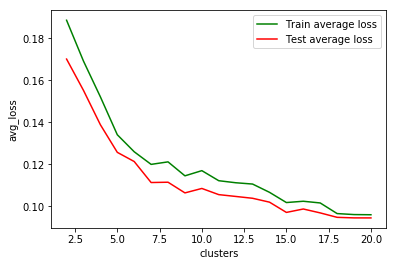

In [45]:
plt.plot([i for i in range(2,21)], train_avg_loss,  color='green', label='Train average loss')
plt.plot([i for i in range(2,21)], test_avg_loss, color='red', label='Test average loss')
plt.legend() 
plt.xlabel('clusters')
plt.ylabel('avg_loss')

plt.savefig('avg_loss.png')
plt.show()

### select optimized model

In [18]:
best_kmode = KModes(n_clusters= 7, init = "Cao", n_init = 1, verbose=1)
best_kmode.fit(label_train_data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 557404, cost: 5149588.0
Run 1, iteration: 2/100, moves: 228198, cost: 4953114.0
Run 1, iteration: 3/100, moves: 81080, cost: 4953114.0


KModes(cat_dissim=<function matching_dissim at 0x119ada9d8>, init='Cao',
       max_iter=100, n_clusters=7, n_init=1, n_jobs=1, random_state=None,
       verbose=1)

In [76]:
best_kmode = KModes(n_clusters= 7, init = "Cao", n_init = 1, verbose=1)
best_kmode.fit(label_train_data)
l, c = best_kmode.predict(label_test_data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 141154, cost: 1215668.0
Run 1, iteration: 2/100, moves: 38799, cost: 1183066.0
Run 1, iteration: 3/100, moves: 9644, cost: 1181966.0
Run 1, iteration: 4/100, moves: 1319, cost: 1181966.0


In [19]:
joblib.dump(best_kmode, "k_modes.pkl")

['k_modes.pkl']

In [20]:
train_data['label'] = best_kmode.labels_

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
train_data.to_csv('clustering_users.csv')

## Clustering visualization

### 1. visualize clusters after PCA

In [53]:
from sklearn.decomposition import PCA
pca = PCA(2)
compress = pca.fit_transform(label_test_data)


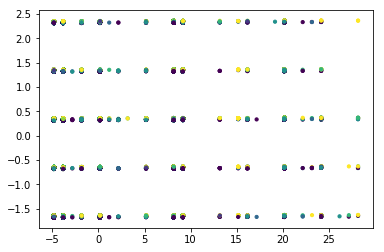

In [54]:
plt.scatter(x=compress[:,0], y=compress[:,1], c=l, s=10)
plt.show()

In [77]:
df2['label'] = l

In [73]:
df2.head()

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,...,Air Farma,Polo Ralph Lauren,Amsterdam Sauer,ARTY Rio,Bola Show,Ehven Pedras,Energia Natural,Mr.Cat,Track & Field,label
0,0,00:00:d6:fa:a6:d6,2019-12-23,"['Mr.Cat', 'Amsterdam Sauer', 'MAC Cosmetics',...",0,1,0,UNKNOWN,15-24,male,...,0,1,1,0,0,0,0,1,0,3
1,1,00:03:ab:da:f1:91,2019-12-27,"['Bola Show', 'Hudson News', 'Maybelline New Y...",0,1,0,US,0-14,male,...,0,0,0,0,1,0,1,0,0,4
2,2,00:03:ab:f6:46:92,2019-12-18,"['Polo Ralph Lauren', 'Livraria Leitura', 'MAC...",0,1,0,US,0-14,female,...,0,1,0,0,0,0,0,0,0,3
3,3,00:03:ab:f7:54:f3,2019-12-15,"['Energia Natural', 'Dufry', 'Hudson News']",0,1,0,US,25-54,male,...,0,0,0,0,0,0,1,0,0,6
4,4,00:03:ab:f7:8a:fd,2019-12-28,"['Sunglass Hut', 'Energia Natural', 'Britt Sho...",0,1,0,US,25-54,female,...,0,0,0,0,0,0,1,0,0,9


### Count the number of points in each cluster

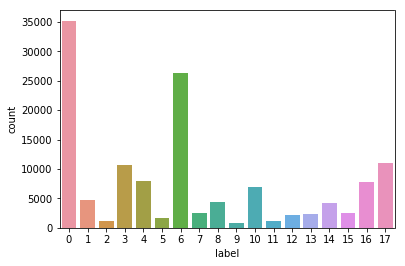

In [75]:
sns.countplot(x = df2['label'])

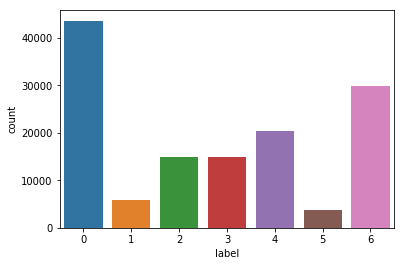

In [78]:
sns.countplot(x = df2['label'])

### Distribution of counts of cluster points in each features

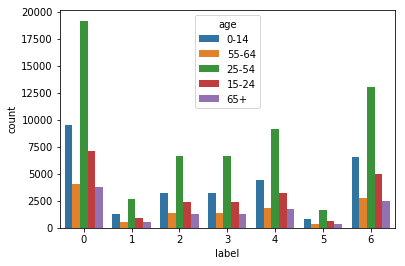

In [80]:
sns.countplot(x = df2['label'], hue = df['age'])

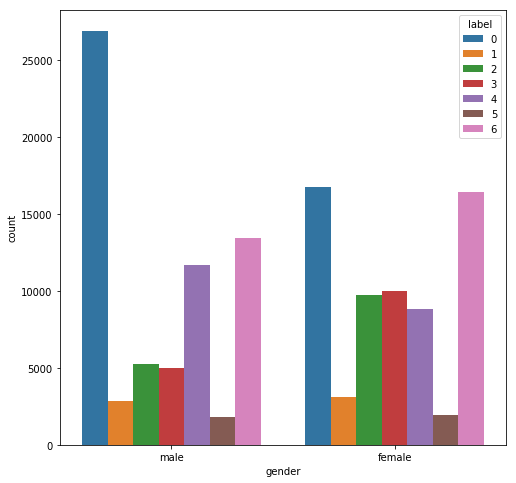

In [93]:
plt.subplots(figsize = (8,8))
sns.countplot(x = df2['gender'], hue = df2['label'])

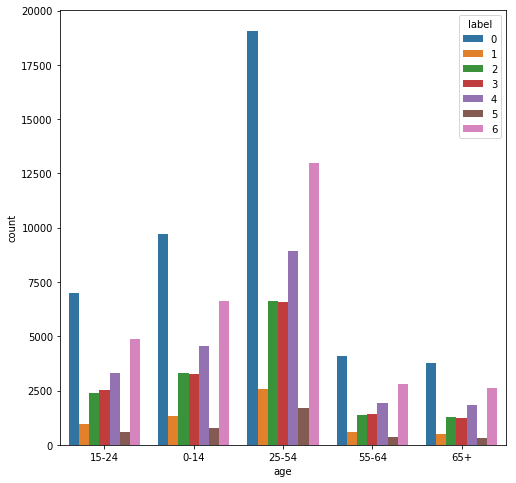

In [96]:
plt.subplots(figsize = (8,8))
sns.countplot(x = df2['age'], hue = df2['label'])

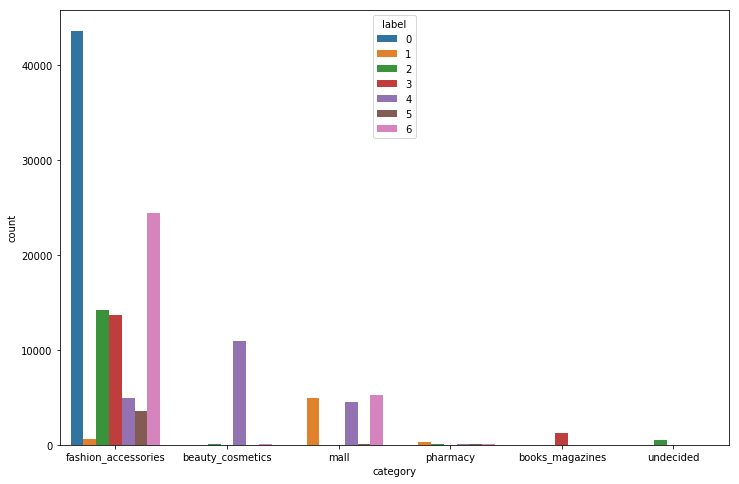

In [97]:
plt.subplots(figsize = (12,8))
sns.countplot(x = df2['category'], hue = df2['label'])

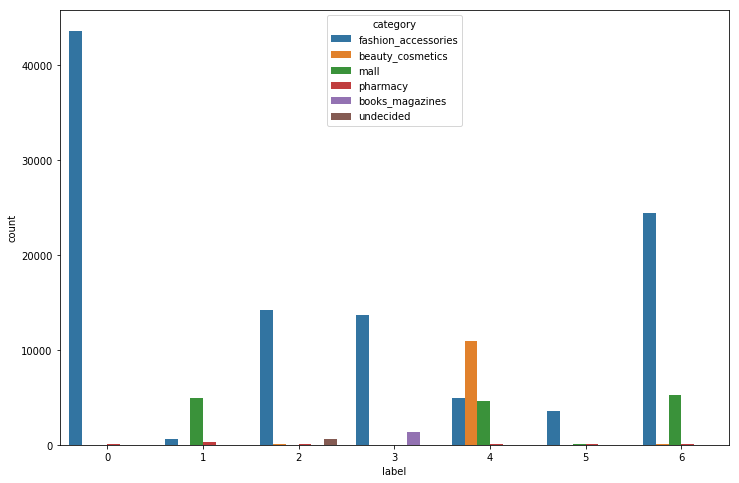

In [101]:
plt.subplots(figsize = (12,8))
sns.countplot(x = df2['label'], hue = df2['category'])

In [100]:
c0

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,...,Air Farma,Polo Ralph Lauren,Amsterdam Sauer,ARTY Rio,Bola Show,Ehven Pedras,Energia Natural,Mr.Cat,Track & Field,label
5,5,00:04:4b:81:2b:94,2019-12-28,"['Amsterdam Sauer', 'Mr.Cat', 'ARTY Rio', 'O B...",0,1,0,UNKNOWN,55-64,male,...,0,0,1,1,0,0,0,1,0,0
8,8,00:05:16:59:ad:2b,2019-12-02,"['Mr.Cat', 'ARTY Rio', 'FOM', 'O Boticário']",0,1,0,UNKNOWN,25-54,male,...,0,0,0,1,0,0,0,1,0,0
10,10,00:05:16:59:ad:2b,2019-12-07,"['Mr.Cat', 'ARTY Rio', 'O Boticário']",0,1,0,UNKNOWN,0-14,female,...,0,0,0,1,0,0,0,1,0,0
13,13,00:05:16:59:ad:2b,2019-12-10,"['Mr.Cat', 'ARTY Rio', 'O Boticário']",0,1,0,UNKNOWN,25-54,male,...,0,0,0,1,0,0,0,1,0,0
16,16,00:05:16:59:ad:2b,2019-12-19,"['Mr.Cat', 'ARTY Rio', 'FOM', 'O Boticário']",0,1,0,UNKNOWN,25-54,male,...,0,0,0,1,0,0,0,1,0,0
19,19,00:05:16:59:ad:2b,2019-12-23,"['Mr.Cat', 'ARTY Rio', 'FOM', 'O Boticário']",0,1,0,UNKNOWN,0-14,male,...,0,0,0,1,0,0,0,1,0,0
22,22,00:05:16:59:ad:2b,2019-12-26,"['Mr.Cat', 'ARTY Rio', 'FOM', 'Amsterdam Sauer...",0,1,0,UNKNOWN,25-54,male,...,0,0,1,1,0,0,0,1,0,0
74,74,00:05:9e:96:a4:a6,2019-12-02,"['ARTY Rio', 'Mr.Cat', 'O Boticário', 'FOM']",0,1,0,TW,25-54,male,...,0,0,0,1,0,0,0,1,0,0
77,77,00:05:9e:96:a4:a6,2019-12-07,"['Mr.Cat', 'ARTY Rio', 'FOM', 'Amsterdam Sauer...",0,1,0,TW,55-64,female,...,0,0,1,1,0,0,0,1,0,0
78,78,00:05:9e:96:a4:a6,2019-12-08,"['Amsterdam Sauer', 'Mr.Cat', 'O Boticário', '...",0,1,0,TW,25-54,female,...,0,0,1,0,0,0,0,1,0,0


### Calculate the proportion of features values

In [122]:
df_count = df2.copy()

In [127]:
df_count['count'] = df_count.groupby(['label'])['ClientMacAddr'].transform('count')

In [129]:
df_count['gender_count'] = df_count.groupby(['label', 'gender'])['ClientMacAddr'].transform('count')
df_count['age_count'] = df_count.groupby(['label', 'age'])['ClientMacAddr'].transform('count')
df_count['category_count'] = df_count.groupby(['label', 'category'])['ClientMacAddr'].transform('count')
df_count['country_count'] = df_count.groupby(['label', 'country'])['ClientMacAddr'].transform('count')

In [131]:
df_count['gender_pro'] = df_count['gender_count'] / df_count['count']
df_count['age_pro'] = df_count['age_count'] / df_count['count']
df_count['category_pro'] = df_count['category_count'] / df_count['count']
df_count['country_pro'] = df_count['country_count'] / df_count['count']

In [132]:
df_count.head()

,Unnamed: 0,ClientMacAddr,localtime,store,level1,level2,level3,country,age,gender,...,label,count,gender_count,age_count,category_count,country_count,gender_pro,age_pro,category_pro,country_pro
0,0,00:00:d6:fa:a6:d6,2019-12-23,"['Mr.Cat', 'Amsterdam Sauer', 'MAC Cosmetics',...",0,1,0,UNKNOWN,15-24,male,...,3,15002,4986,2521,13672,8200,0.332356,0.168044,0.911345,0.546594
1,1,00:03:ab:da:f1:91,2019-12-27,"['Bola Show', 'Hudson News', 'Maybelline New Y...",0,1,0,US,0-14,male,...,4,20488,11692,4536,4902,4277,0.570676,0.221398,0.239262,0.208756
2,2,00:03:ab:f6:46:92,2019-12-18,"['Polo Ralph Lauren', 'Livraria Leitura', 'MAC...",0,1,0,US,0-14,female,...,3,15002,10016,3260,13672,2861,0.667644,0.217304,0.911345,0.190708
3,3,00:03:ab:f7:54:f3,2019-12-15,"['Energia Natural', 'Dufry', 'Hudson News']",0,1,0,US,25-54,male,...,6,29873,13446,12978,24437,6079,0.450105,0.434439,0.818030,0.203495
4,4,00:03:ab:f7:8a:fd,2019-12-28,"['Sunglass Hut', 'Energia Natural', 'Britt Sho...",0,1,0,US,25-54,female,...,1,5915,3079,2560,624,1101,0.520541,0.432798,0.105495,0.186137


### Visualize the distribution of features in each cluster, and identify distinguish clusters

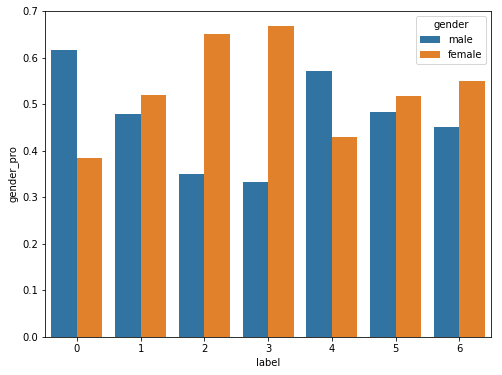

In [151]:
plt.subplots(figsize = (8,6))
sns.barplot(x='label',y='gender_pro',data=df_count,hue='gender')

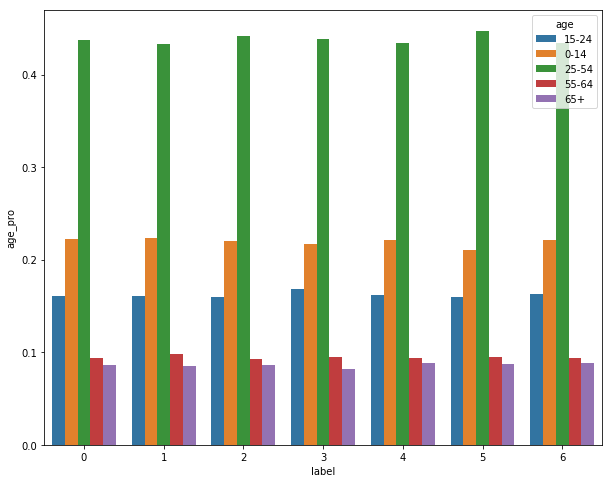

In [152]:
plt.subplots(figsize = (10,8))
sns.barplot(x='label',y='age_pro',data=df_count,hue='age')

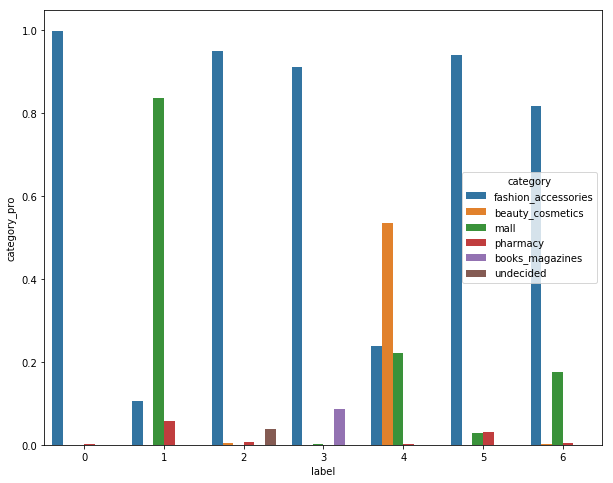

In [143]:
plt.subplots(figsize = (10,8))
sns.barplot(x='label',y='category_pro',data=df_count,hue='category')

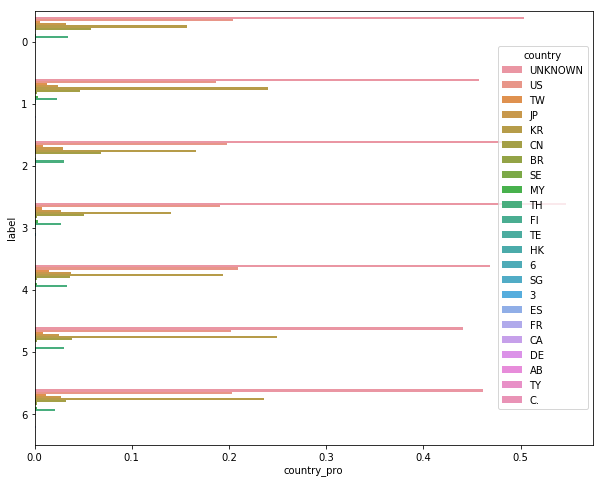

In [150]:
plt.subplots(figsize = (10, 8))
sns.barplot(x='country_pro',y='label',data=df_count,hue='country', orient='h')